[Exploration Phase 1](#explore1)

[Clustering](#clustering)

[Exploration Phase 2](#explore2)

# Exploration Phase 1 <a class="anchor" id="explore1">

Hypotheses:
- Logerror is going to be worse in on the highest and lowest value homes
- Logerror will be influenced by geography
- Logerror will be mildly correlated with transaction month
- Logerror will be influenced by number of observations per land use type

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

#modeling
from sklearn.cluster import KMeans

#my modules
import utils
import wrangle_zillow as wz

## Data Acquisition and Preparation

In [2]:
#acquire, prep, split
tr, te, val = wz.wrangle_zillow(val_ratio=.15,test_ratio=.15)

/Users/caytschlichting/codeup-data-science/zillow-clustering-project/wrangle_zillow.py:185: DtypeWarning: Columns (63) have mixed types.Specify dtype option on import or set low_memory=False.
  df = getZillowData()


In [3]:
tr.shape

(40525, 21)

In [4]:
te.shape

(8685, 21)

In [5]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40525 entries, 14720402 to 12082600
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   logerror                                    40525 non-null  float64
 1   bath                                        40525 non-null  float64
 2   bed                                         40525 non-null  int64  
 3   sf                                          40525 non-null  int64  
 4   fullbathcnt                                 40525 non-null  int64  
 5   lat                                         40525 non-null  int64  
 6   lon                                         40525 non-null  int64  
 7   roomcnt                                     40525 non-null  int64  
 8   yearbuilt                                   40525 non-null  int64  
 9   value                                       40525 non-null  float64
 10  

##### create EDA dataframe

In [6]:
eda_cols = ['value','logerror','bed','bath','fullbathcnt','roomcnt',\
            'sf','yearbuilt','trans_month','landusedesc','county','lat','lon']
tr_eda = tr[eda_cols]
tr_eda.head(2)

value  logerror  bed  bath  fullbathcnt  roomcnt    sf  \
parcelid                                                              
14720402  327178.0 -0.005527    3   2.5            2        0  1689   
11180963  590000.0  0.023727    4   3.0            3        0  2174   

          yearbuilt  trans_month                landusedesc      county  \
parcelid                                                                  
14720402       1989            9                Condominium      Orange   
11180963       1965            8  Single Family Residential  LosAngeles   

               lat        lon  
parcelid                       
14720402  33610842 -117621681  
11180963  34277861 -118536227

##### Show Distributions

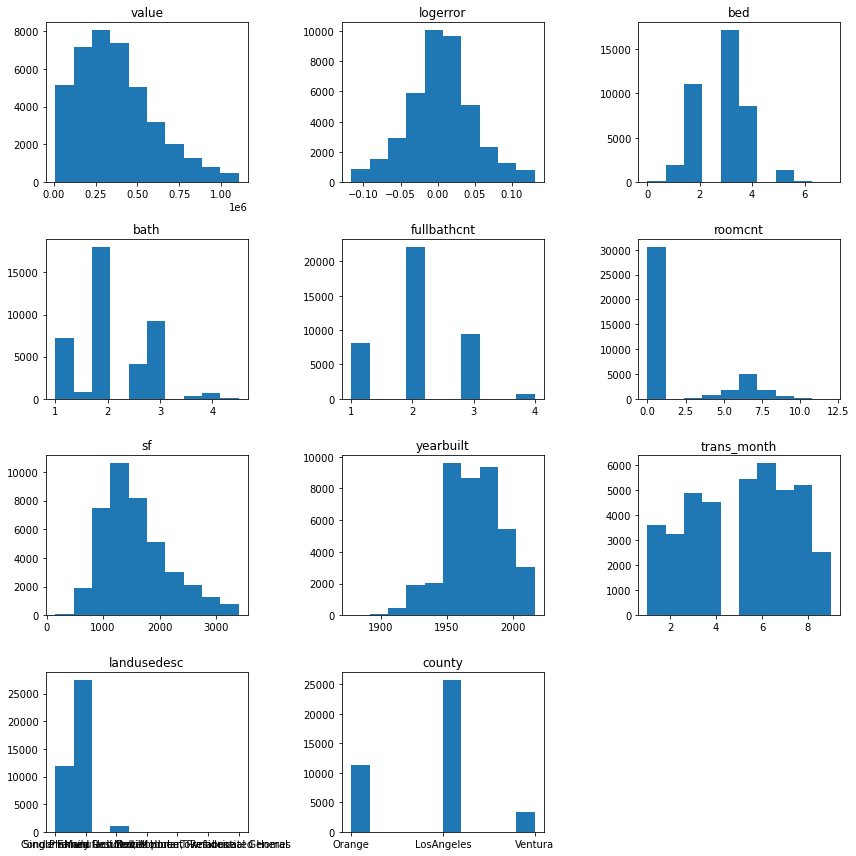

In [7]:
plt.figure(figsize=(12,12))
for cnt, c in enumerate(tr_eda.columns[:-2]):
    plt.subplot(4,3,cnt+1)
    plt.hist(tr_eda[c])
    plt.title(c)

plt.tight_layout()

##### Look at how logerror interacts with home values

In [8]:
tr_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40525 entries, 14720402 to 12082600
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        40525 non-null  float64
 1   logerror     40525 non-null  float64
 2   bed          40525 non-null  int64  
 3   bath         40525 non-null  float64
 4   fullbathcnt  40525 non-null  int64  
 5   roomcnt      40525 non-null  int64  
 6   sf           40525 non-null  int64  
 7   yearbuilt    40525 non-null  int64  
 8   trans_month  40525 non-null  int64  
 9   landusedesc  40525 non-null  object 
 10  county       40525 non-null  object 
 11  lat          40525 non-null  int64  
 12  lon          40525 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 4.3+ MB


<AxesSubplot:xlabel='value', ylabel='logerror'>

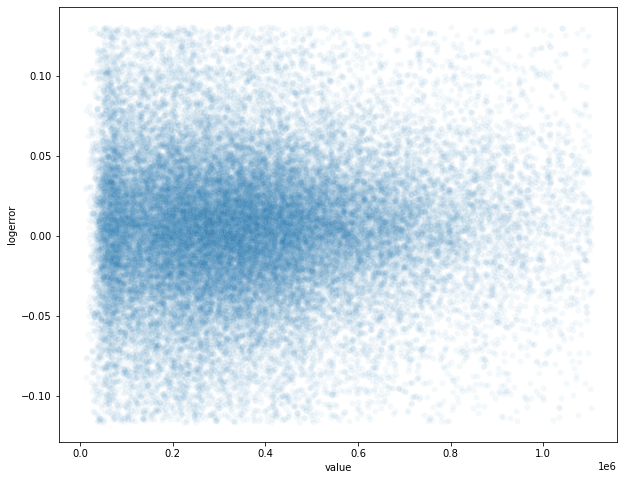

In [9]:
plt.figure(figsize=(10,8))

sns.scatterplot(data=tr_eda,x='value',y='logerror',alpha=.05)

**time permitting** run a hypothesis test

##### How does logerror relate with geography?

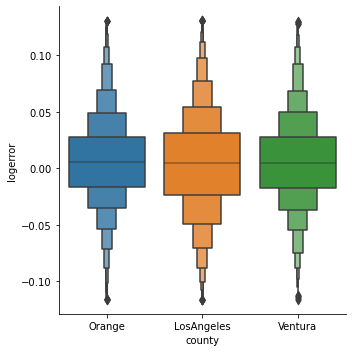

In [10]:
sns.catplot(data=tr_eda,x='county',y='logerror',kind='boxen')

<AxesSubplot:xlabel='lon', ylabel='lat'>

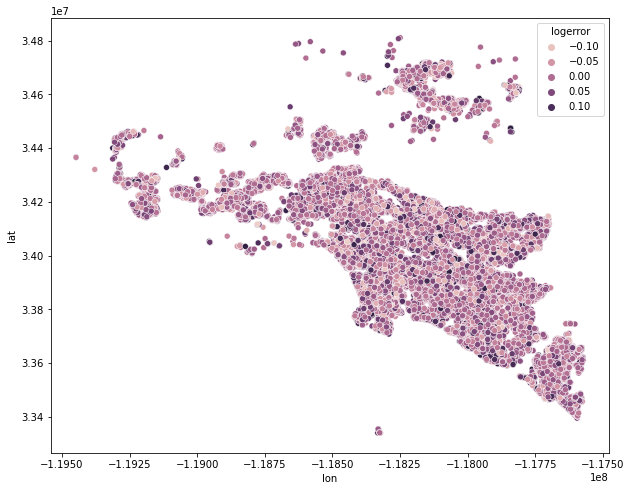

In [11]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=tr_eda,x='lon',y='lat',hue='logerror')

**time permitting** redo the above graph and aggregate by a certain resolution. Need to make that function

##### How does logerror relate to transaction month?

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


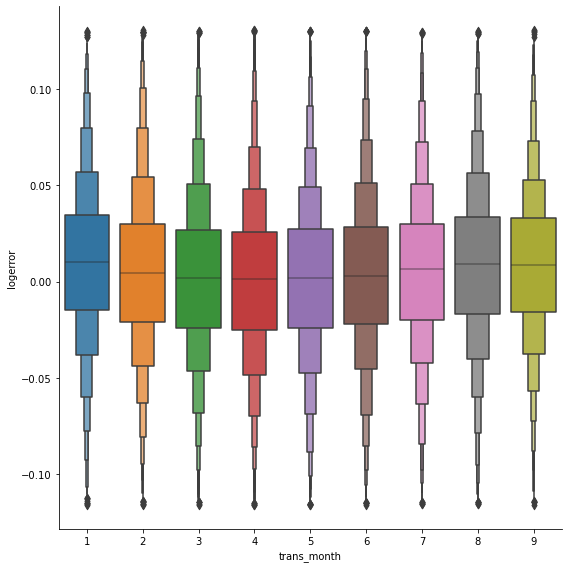

In [12]:
sns.catplot(data=tr_eda,x='trans_month',y='logerror',kind='boxen',size=8); 

**time permitting** run hypothesis test on this.  (each month against the population?)

##### How does logerror relate to land use type

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


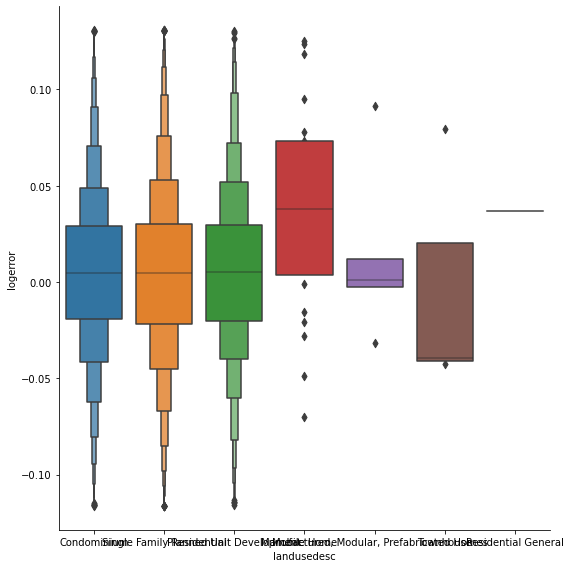

In [13]:
sns.catplot(data=tr_eda,x='landusedesc',y='logerror',kind='boxen',size=8); 

# Clustering <a class="anchor" id="clustering">

In [14]:
tr.columns

Index(['logerror', 'bath', 'bed', 'sf', 'fullbathcnt', 'lat', 'lon', 'roomcnt',
       'yearbuilt', 'value', 'landusedesc', 'trans_month', 'county', 'Orange',
       'Ventura', 'Manufactured, Modular, Prefabricated Homes', 'Mobile Home',
       'Planned Unit Development', 'Residential General',
       'Single Family Residential', 'Townhouse'],
      dtype='object')

##### Break out model input columns

In [15]:
X_cols = ['bath', 'bed', 'sf', 'fullbathcnt', 'lat', 'lon', 'roomcnt','yearbuilt', 'trans_month',\
  'Orange', 'Ventura','Manufactured, Modular, Prefabricated Homes', 'Mobile Home',\
  'Planned Unit Development', 'Residential General','Single Family Residential', 'Townhouse']

X_tr = tr[X_cols]
X_te = te[X_cols]
X_val = val[X_cols]

In [16]:
#Repeat and remove the county data.
X_cols_noCnty = ['bath', 'bed', 'sf', 'fullbathcnt', 'lat', 'lon', 'roomcnt','yearbuilt', 'trans_month',\
  'Manufactured, Modular, Prefabricated Homes', 'Mobile Home',\
  'Planned Unit Development', 'Residential General','Single Family Residential', 'Townhouse']

X_tr_noCnty = tr[X_cols_noCnty]
X_te_noCnty = te[X_cols_noCnty]
X_val_noCnty = val[X_cols_noCnty]

In [17]:
X_tr_noCnty.columns

Index(['bath', 'bed', 'sf', 'fullbathcnt', 'lat', 'lon', 'roomcnt',
       'yearbuilt', 'trans_month',
       'Manufactured, Modular, Prefabricated Homes', 'Mobile Home',
       'Planned Unit Development', 'Residential General',
       'Single Family Residential', 'Townhouse'],
      dtype='object')

##### Scale the data

In [18]:
scale_cols = ['bath', 'bed', 'sf', 'fullbathcnt', 'lat', 'lon', 'roomcnt','yearbuilt', 'trans_month']
X_tr_scaled, X_te_scaled, X_val_scaled = utils.scale_X(X_tr,X_te,X_val,columns=scale_cols,kind='minmax')

In [19]:
X_tr_scaled.describe()

bath           bed            sf   fullbathcnt           lat  \
count  40525.000000  40525.000000  40525.000000  40525.000000  40525.000000   
mean       0.324745      0.416096      0.437104      0.357039      0.453972   
std        0.204315      0.134220      0.179871      0.236533      0.182827   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.285714      0.285714      0.306034      0.333333      0.317652   
50%        0.285714      0.428571      0.402094      0.333333      0.455589   
75%        0.571429      0.571429      0.534791      0.666667      0.571730   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                lon       roomcnt     yearbuilt   trans_month        Orange  \
count  40525.000000  40525.000000  40525.000000  40525.000000  40525.000000   
mean       0.671261      0.130849      0.665938      0.510028      0.281234   
std        0.193192      0.237981      0.158377      0.294089      0.449607   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.555655      0.000000      0.557971      0.250000      0.000000   
50%        0.691767      0.000000      0.673913      0.500000      0.000000   
75%        0.819204      0.000000      0.782609      0.750000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Ventura  Manufactured, Modular, Prefabricated Homes   Mobile Home  \
count  40525.000000                                40525.000000  40525.000000   
mean       0.082492                                    0.000123      0.000617   
std        0.275117                                    0.011107      0.024830   
min        0.000000                                    0.000000      0.000000   
25%        0.000000                                    0.000000      0.000000   
50%        0.000000                                    0.000000      0.000000   
75%        0.000000                                    0.000000      0.000000   
max        1.000000                                    1.000000      1.000000   

       Planned Unit Development  Residential General  \
count              40525.000000         40525.000000   
mean                   0.025713             0.000025   
std                    0.158278             0.004968   
min                    0.000000             0.000000   
25%                    0.000000             0.000000   
50%                    0.000000             0.000000   
75%                    0.000000             0.000000   
max                    1.000000             1.000000   

       Single Family Residential     Townhouse  
count               40525.000000  40525.000000  
mean                    0.679605      0.000074  
std                     0.466634      0.008604  
min                     0.000000      0.000000  
25%                     0.000000      0.000000  
50%                     1.000000      0.000000  
75%                     1.000000      0.000000  
max                     1.000000      1.000000

In [20]:
#Repeat for no county data
X_tr_noCnty_scaled = X_tr_scaled.drop(columns=['Orange','Ventura'])
X_te_noCnty_scaled = X_te_scaled.drop(columns=['Orange','Ventura'])
X_val_noCnty_scaled = X_val_scaled.drop(columns=['Orange','Ventura'])

In [21]:
X_tr_noCnty_scaled.columns

Index(['bath', 'bed', 'sf', 'fullbathcnt', 'lat', 'lon', 'roomcnt',
       'yearbuilt', 'trans_month',
       'Manufactured, Modular, Prefabricated Homes', 'Mobile Home',
       'Planned Unit Development', 'Residential General',
       'Single Family Residential', 'Townhouse'],
      dtype='object')

In [22]:
#Create simple inputs for my clusters
# time permitting - try it with a condo/house flag
simp_cols = ['bed', 'sf', 'Orange','Ventura']

X_tr_simp_scaled = X_tr_scaled[simp_cols]
X_te_simp_scaled = X_te_scaled[simp_cols]
X_val_simp_scaled = X_val_scaled[simp_cols]

In [23]:
#Try with only room inputs
room_cols = ['bath','bed','roomcnt']

X_tr_room_scaled = X_tr_scaled[room_cols]
X_te_room_scaled = X_te_scaled[room_cols]
X_val_room_scaled = X_val_scaled[room_cols]

#Try with primary rooms and sf
roomSF_cols = ['bath','bed','sf']

X_tr_roomSF_scaled = X_tr_scaled[roomSF_cols]
X_te_roomSF_scaled = X_te_scaled[roomSF_cols]
X_val_roomSF_scaled = X_val_scaled[roomSF_cols]

##### Look at iniertia for different numer of clusters (k)

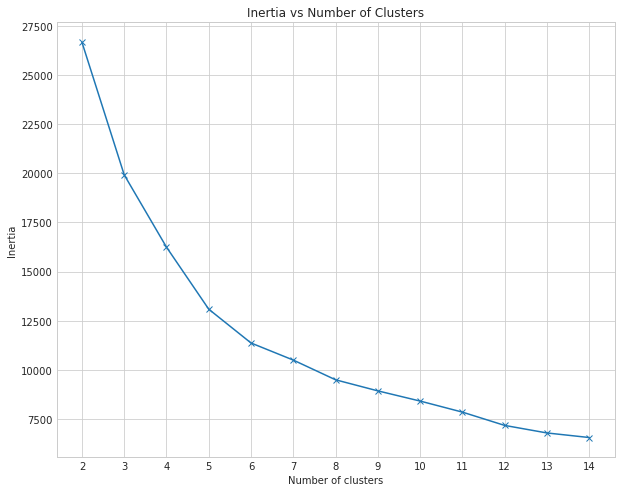

In [24]:
plt.figure(figsize=(10,8))
with plt.style.context('seaborn-whitegrid'):
    #generate model, fit, get inertia for multiple values for num_clusters
    pd.Series({k: KMeans(k).fit(X_tr_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 15))
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of Clusters')

**Notes:** Based off the above inertia chart, 5 or 6 clusters will likely be good when using all the features

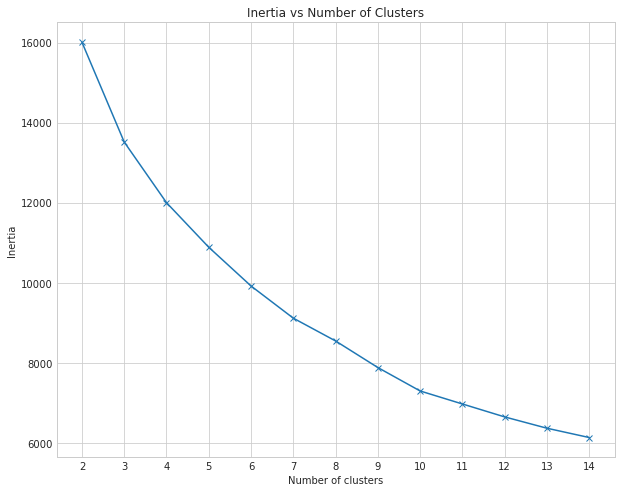

In [25]:
plt.figure(figsize=(10,8))
with plt.style.context('seaborn-whitegrid'):
    #generate model, fit, get inertia for multiple values for num_clusters
    pd.Series({k: KMeans(k).fit(X_tr_noCnty_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 15))
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of Clusters')

**Notes:** very curvaceous, pick 4 for this one

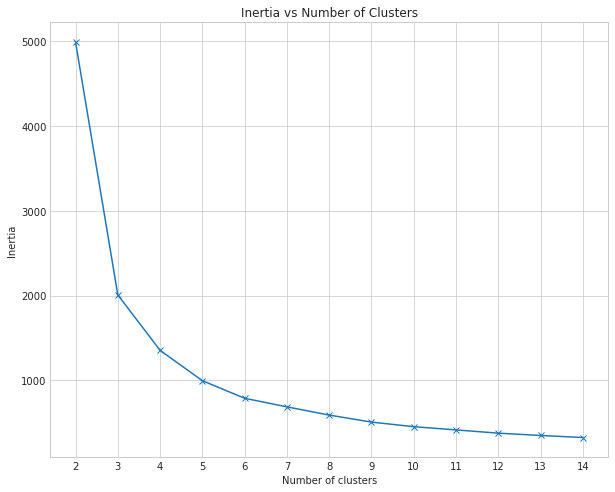

In [26]:
plt.figure(figsize=(10,8))
with plt.style.context('seaborn-whitegrid'):
    #generate model, fit, get inertia for multiple values for num_clusters
    pd.Series({k: KMeans(k).fit(X_tr_simp_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 15))
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of Clusters')

**Notes:** 3 or 4 would work for this one.  Choosing 4 so it isn't just clustered by county :D

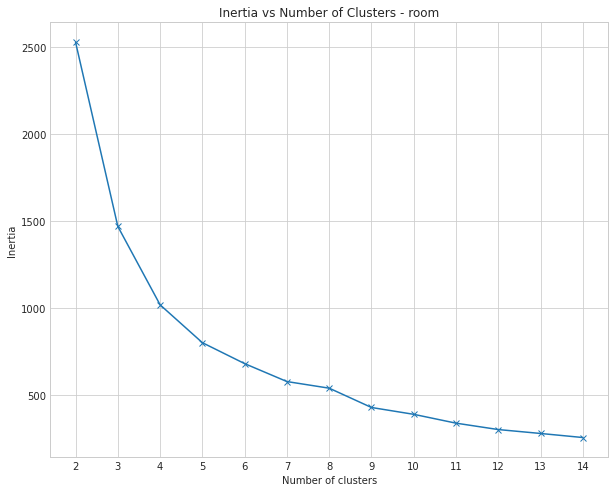

In [27]:
plt.figure(figsize=(10,8))
with plt.style.context('seaborn-whitegrid'):
    #generate model, fit, get inertia for multiple values for num_clusters
    pd.Series({k: KMeans(k).fit(X_tr_room_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 15))
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of Clusters - room')

**Notes:** 4 is a good choice here

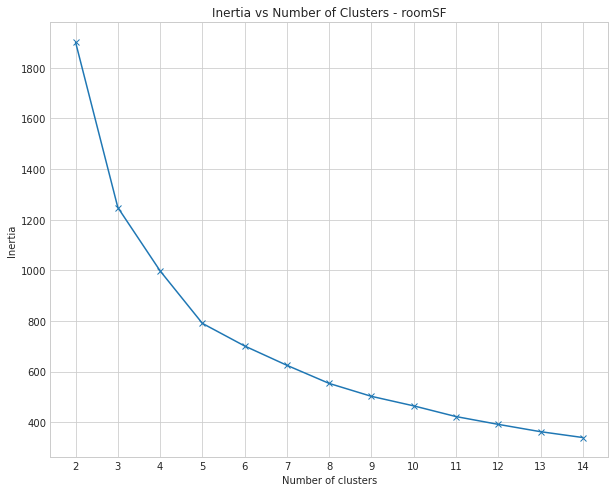

In [28]:
plt.figure(figsize=(10,8))
with plt.style.context('seaborn-whitegrid'):
    #generate model, fit, get inertia for multiple values for num_clusters
    pd.Series({k: KMeans(k).fit(X_tr_roomSF_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 15))
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of Clusters - roomSF')

**Notes:** 3 or 5 would work here

##### Create models and store the cluster as a new feature

In [29]:
model = KMeans(6).fit(X_tr_scaled)

#get clusters
X_tr_scaled['cluster'] = model.predict(X_tr_scaled)
tr['cluster'] = X_tr_scaled['cluster'].copy()

In [30]:
#get centroids
centroids = pd.DataFrame(model.cluster_centers_, columns=X_tr_scaled.columns[:-1])

In [31]:
X_tr_scaled.cluster.value_counts()

5    13383
3     8128
2     7422
1     4274
0     3975
4     3343
Name: cluster, dtype: int64

In [32]:
#repeat for dataset w/o county info
model_noCnty = KMeans(4).fit(X_tr_noCnty_scaled)

#get clusters
X_tr_noCnty_scaled['cluster'] = model_noCnty.predict(X_tr_noCnty_scaled)
tr['cluster_noCnty'] = X_tr_noCnty_scaled['cluster'].copy()

In [33]:
#get centroids
centroids_noCnty = pd.DataFrame(model_noCnty.cluster_centers_, columns=X_tr_noCnty_scaled.columns[:-1])

In [34]:
#repeat for simple inputs
model_simp = KMeans(4).fit(X_tr_simp_scaled)

#get clusters
X_tr_simp_scaled['cluster'] = model_simp.predict(X_tr_simp_scaled)
tr['cluster_simp'] = X_tr_simp_scaled['cluster'].copy()

/var/folders/dn/dr6y15951wq03xbh2xr9khq40000gn/T/ipykernel_85008/1159440792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr_simp_scaled['cluster'] = model_simp.predict(X_tr_simp_scaled)


In [35]:
X_tr_room_scaled.columns

Index(['bath', 'bed', 'roomcnt'], dtype='object')

In [36]:
#repeat for room inputs
model_room = KMeans(4).fit(X_tr_room_scaled)

#get clusters
X_tr_room_scaled['cluster'] = model_room.predict(X_tr_room_scaled)
tr['cluster_room'] = X_tr_room_scaled['cluster'].copy()

/var/folders/dn/dr6y15951wq03xbh2xr9khq40000gn/T/ipykernel_85008/1844977168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr_room_scaled['cluster'] = model_room.predict(X_tr_room_scaled)


In [37]:
#repeat for roomSF inputs
model_roomSF = KMeans(3).fit(X_tr_roomSF_scaled)

#get clusters
X_tr_roomSF_scaled['cluster'] = model_roomSF.predict(X_tr_roomSF_scaled)
tr['cluster_roomSF'] = X_tr_roomSF_scaled['cluster'].copy()

/var/folders/dn/dr6y15951wq03xbh2xr9khq40000gn/T/ipykernel_85008/4148715885.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr_roomSF_scaled['cluster'] = model_roomSF.predict(X_tr_roomSF_scaled)


In [38]:
#get centroids
centroids_roomSF = pd.DataFrame(model_roomSF.cluster_centers_, columns=X_tr_roomSF_scaled.columns[:-1])

# Exploration Phase 2: Using clustered data <a class="anchor" id="explore2">
    

##### How does logerror interact with value 

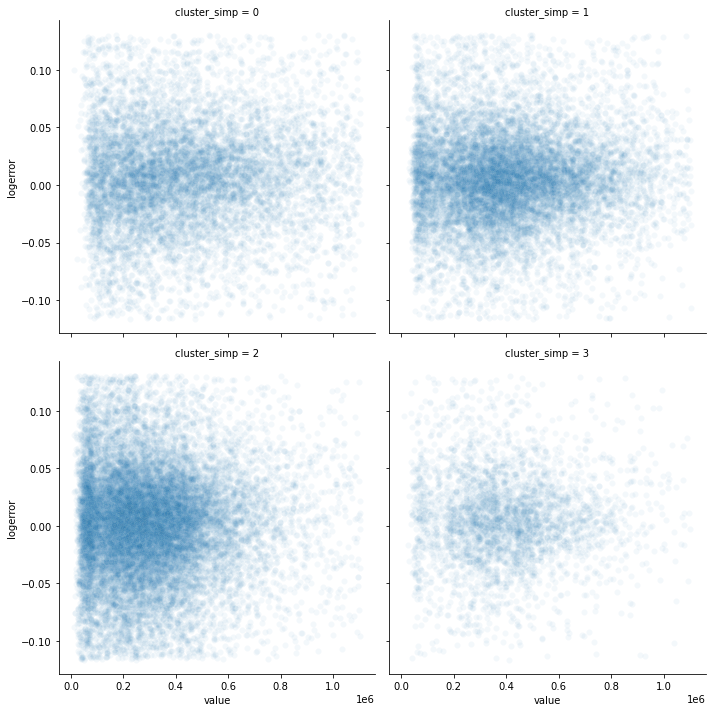

In [39]:
sns.relplot(data=tr,x='value',y='logerror',col='cluster_simp',col_wrap=2,palette='colorblind',alpha=.05)

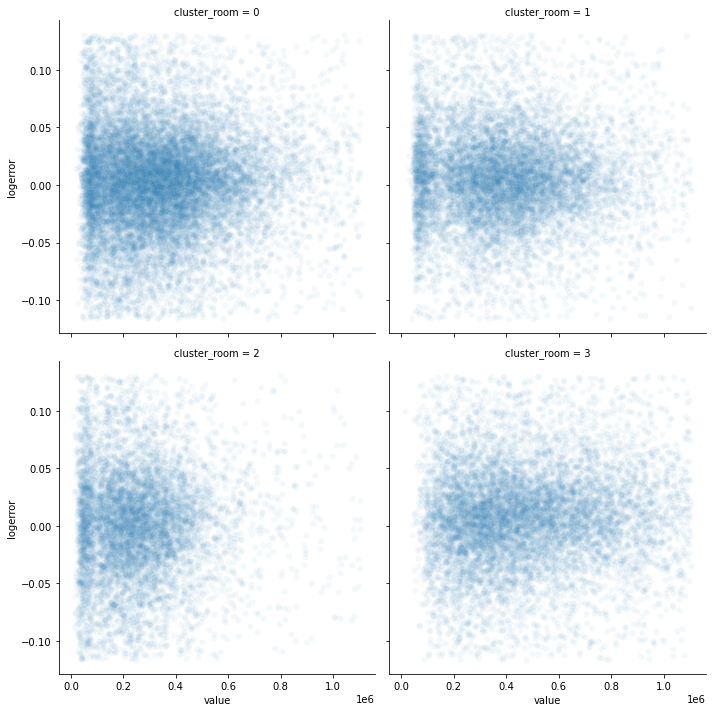

In [40]:
sns.relplot(data=tr,x='value',y='logerror',col='cluster_room',col_wrap=2,palette='colorblind',alpha=.05)

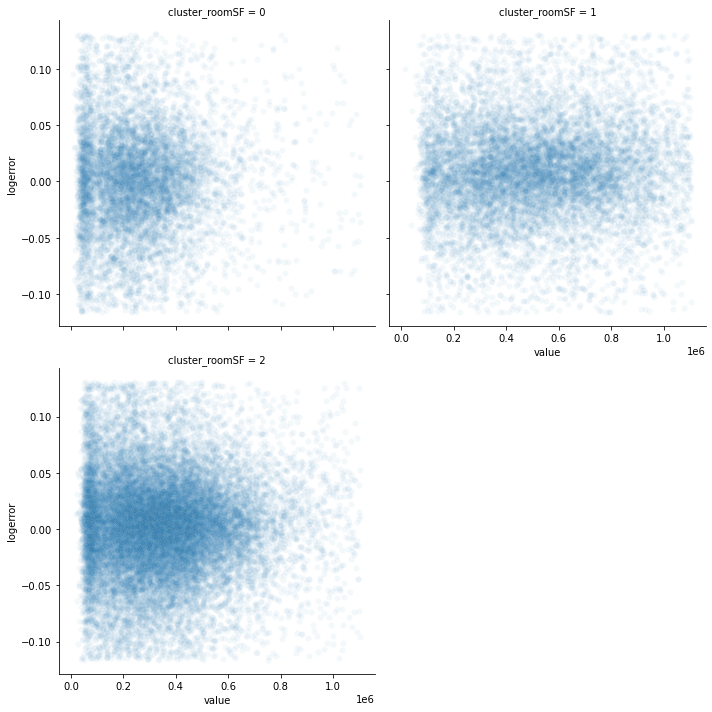

In [41]:
sns.relplot(data=tr,x='value',y='logerror',col='cluster_roomSF',col_wrap=2,palette='colorblind',alpha=.05)

Not seeing too much that relates logerror to value

##### How does logerror relate to geography - broken out by cluster

<AxesSubplot:xlabel='lon', ylabel='lat'>

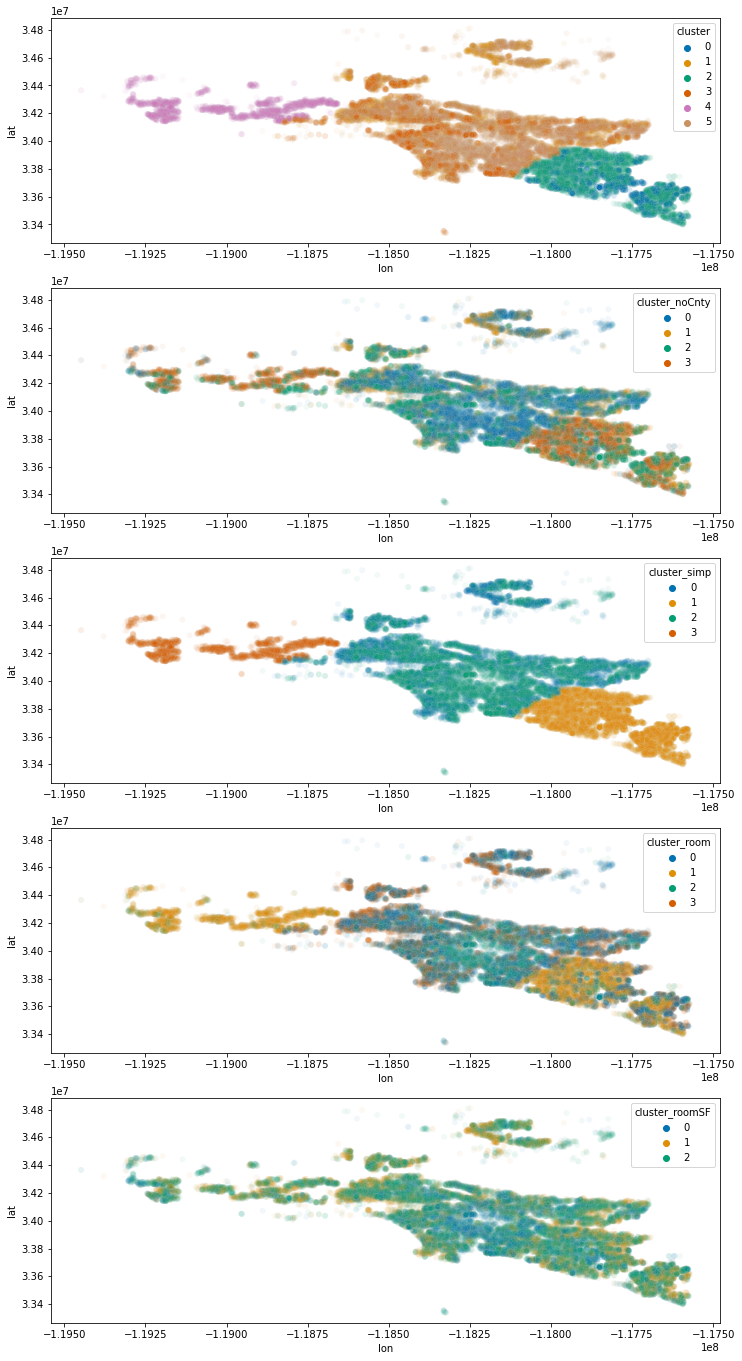

In [42]:
#First look at if we see any obvious clusters by geography
plt.figure(figsize=(12,24))
plt.subplot(511)
sns.scatterplot(data=tr,x='lon',y='lat',hue='cluster',palette='colorblind',alpha=.05)
plt.subplot(512)
sns.scatterplot(data=tr,x='lon',y='lat',hue='cluster_noCnty',palette='colorblind',alpha=.05)
plt.subplot(513)
sns.scatterplot(data=tr,x='lon',y='lat',hue='cluster_simp',palette='colorblind',alpha=.05)
plt.subplot(514)
sns.scatterplot(data=tr,x='lon',y='lat',hue='cluster_room',palette='colorblind',alpha=.05)
plt.subplot(515)
sns.scatterplot(data=tr,x='lon',y='lat',hue='cluster_roomSF',palette='colorblind',alpha=.05)

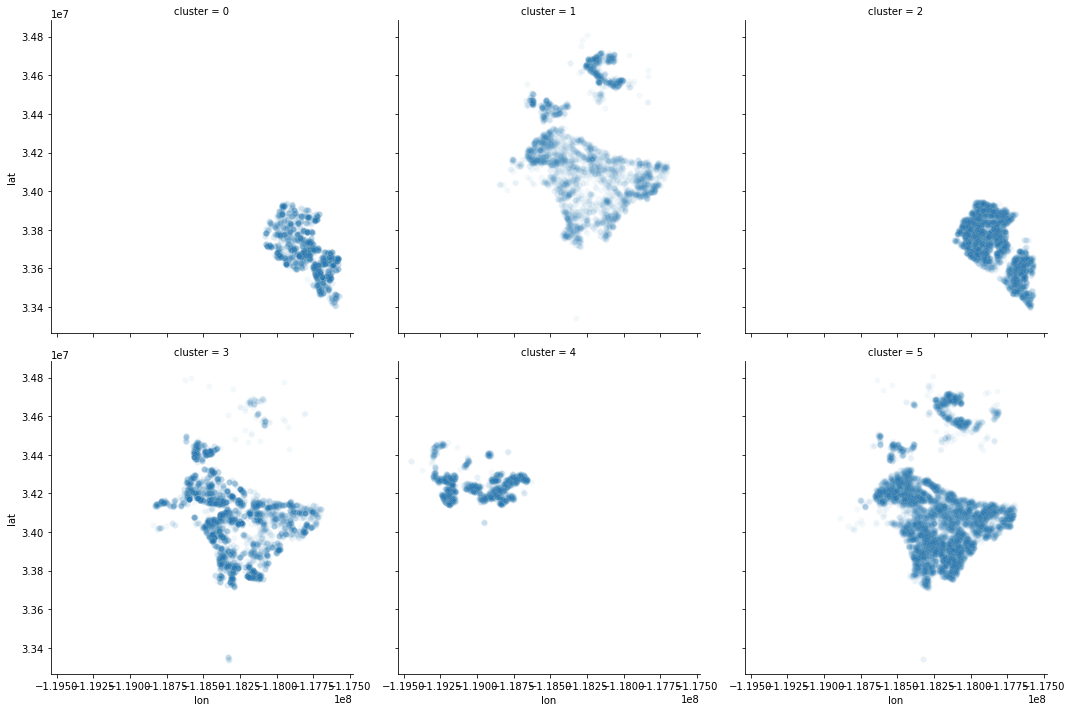

In [43]:
sns.relplot(data=tr,x='lon',y='lat',col='cluster',col_wrap=3,palette='colorblind',alpha=.05)

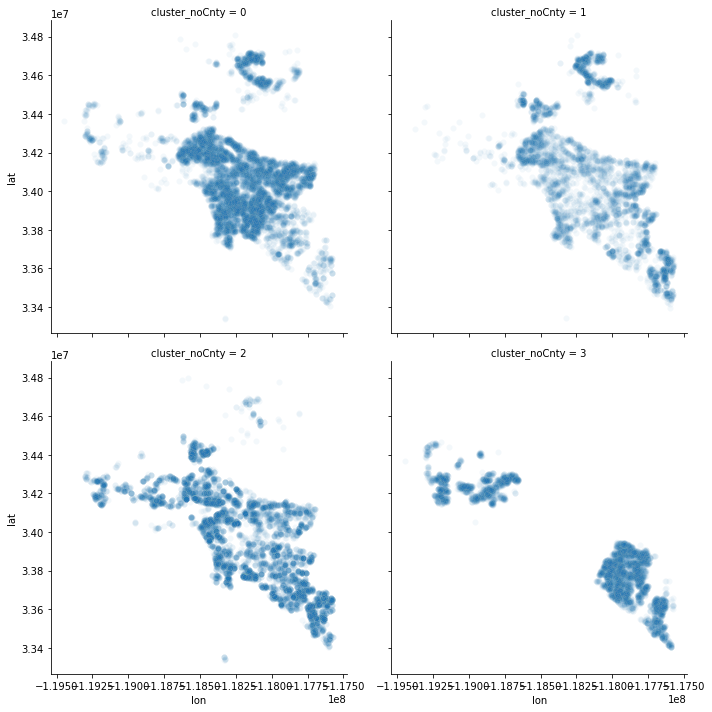

In [44]:
#repeat w/o county data
sns.relplot(data=tr,x='lon',y='lat',col='cluster_noCnty',col_wrap=2,palette='colorblind',alpha=.05)

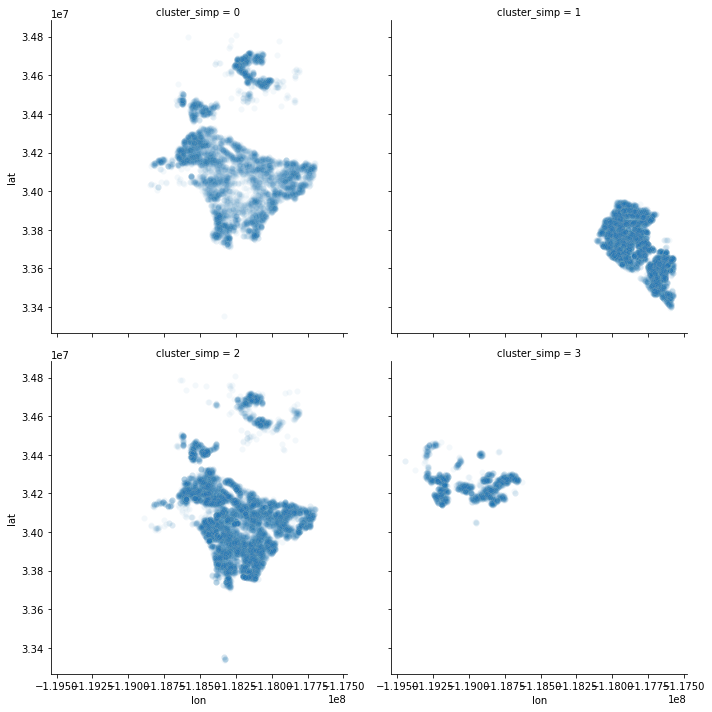

In [45]:
#repeat w/ simp dataset
sns.relplot(data=tr,x='lon',y='lat',col='cluster_simp',col_wrap=2,palette='colorblind',alpha=.05)

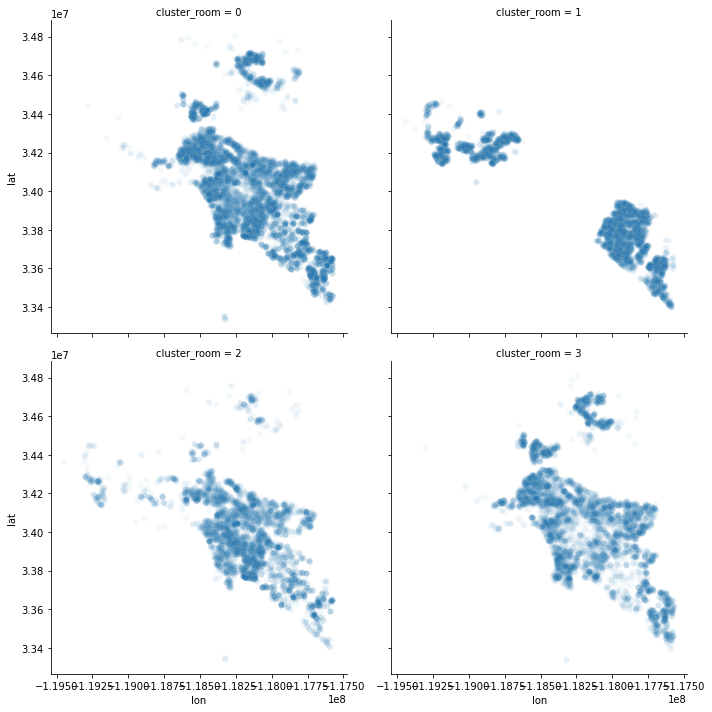

In [46]:
#repeat w/ room dataset
sns.relplot(data=tr,x='lon',y='lat',col='cluster_room',col_wrap=2,palette='colorblind',alpha=.05)

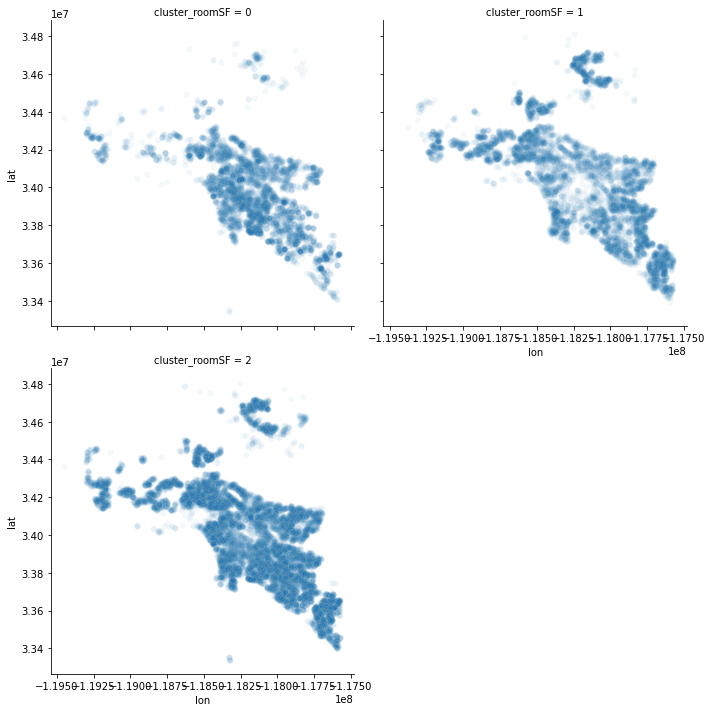

In [47]:
#repeat w/ roomSF dataset
sns.relplot(data=tr,x='lon',y='lat',col='cluster_roomSF',col_wrap=2,palette='colorblind',alpha=.05)

**Notes:** The simple clustering is essentially breaking out by county, then splitting LA into two elements.  Let's try and visualize those elements of LA

In [48]:
X_tr_simp_scaled.columns

Index(['bed', 'sf', 'Orange', 'Ventura', 'cluster'], dtype='object')

In [49]:
X_tr_simp_scaled.cluster.value_counts()

2    17432
1    11397
0     8353
3     3343
Name: cluster, dtype: int64

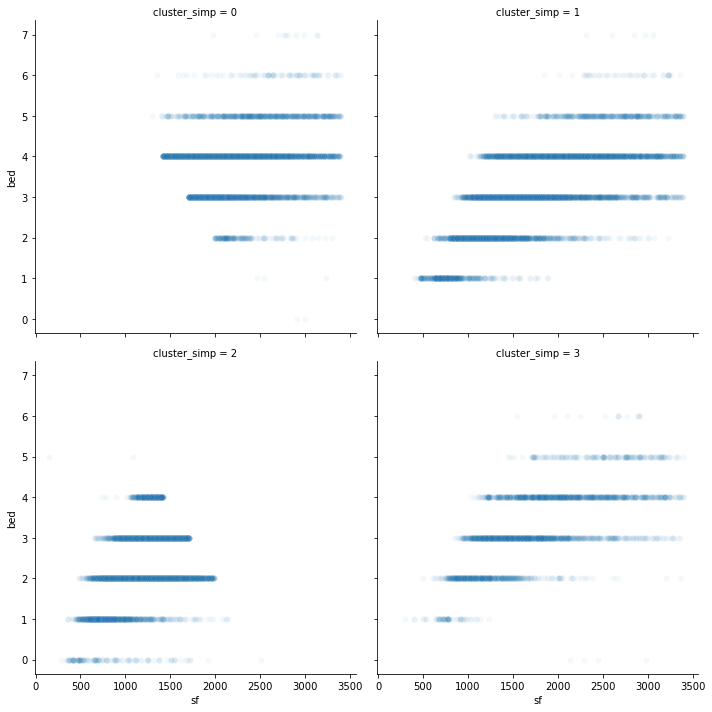

In [50]:
sns.relplot(data=tr,x='sf',y='bed',col='cluster_simp',col_wrap=2,palette='colorblind',alpha=.05)

In [51]:
tr.county.value_counts()

LosAngeles    25785
Orange        11397
Ventura        3343
Name: county, dtype: int64

**Notes:** LA was essentially broken into low squarefootage and bath (the bulk of the LA observations), and high sf and bath

Moving forward I want to use this last clustering to model my data.  Let's rename this as:

{
0:'Orange'

1:'LA_expensive'

2:'Ventura'

3:'LA_general'
}

In [52]:
tr.cluster_simp = tr.cluster_simp.map({0:'Orange',1:'LA_expensive',2:'Ventura',3:'LA_general'})
tr.cluster_simp.value_counts()

Ventura         17432
LA_expensive    11397
Orange           8353
LA_general       3343
Name: cluster_simp, dtype: int64

Now look at room clustering

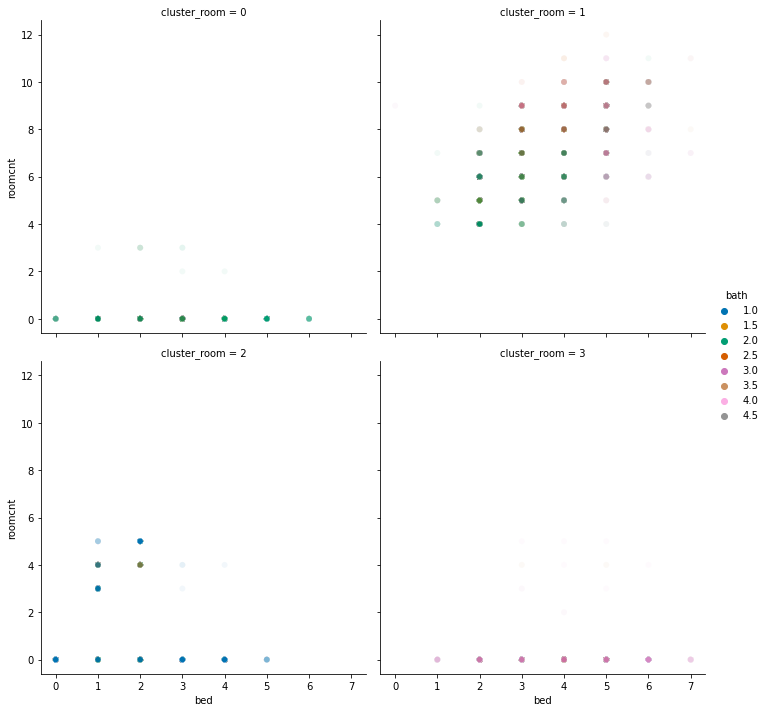

In [53]:
sns.relplot(data=tr,x='bed',y='roomcnt',hue='bath',col='cluster_room',col_wrap=2,palette='colorblind',alpha=.05)

**Notes:** looks like maybe 3 clusters would have been better.  Both cluster 0 and 3 are primarily 0 extra rooms, with 2-3 baths.  Cluster 1 is mostly properties with 5+ bonus rooms.  Cluster 2 is a mix of properties with 0-5 bonus rooms, and a low number of baths.

Looking at the other clusters:


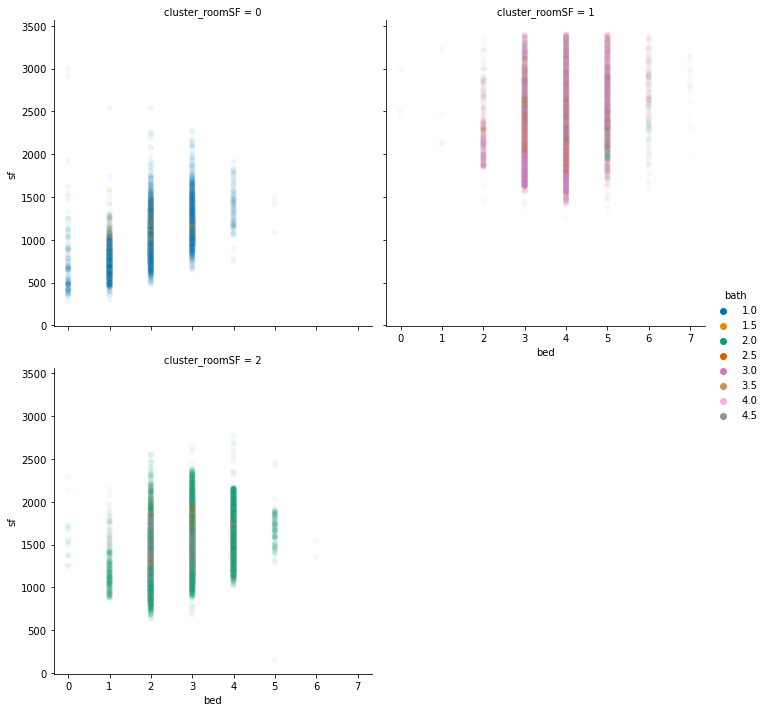

In [54]:
sns.relplot(data=tr,x='bed',y='sf',hue='bath',col='cluster_roomSF',col_wrap=2,palette='colorblind',alpha=.05)

<IPython.core.display.Javascript object>


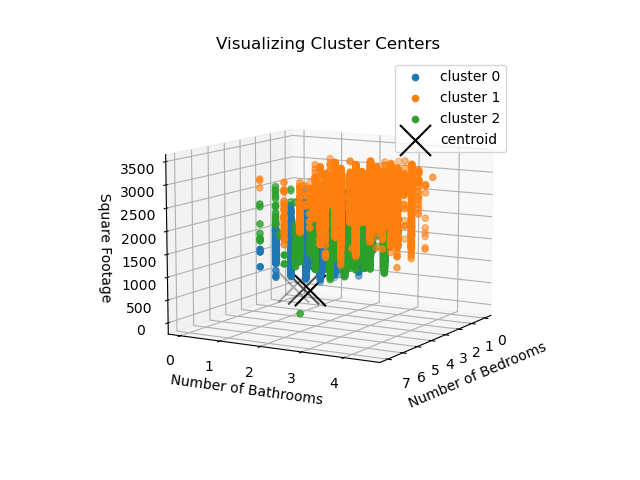

In [57]:
#PLOTTING    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#PLOT THE POINTS AND CENTROIDS FOR 3 CLUSTERS
#Loop over the rows, grouped by cluster - plot each cluster
for grp, subset in tr.groupby('cluster_roomSF'):
    #x is first in pair, y is second
    ax.scatter(subset['bed'],subset['bath'],subset['sf'],
               label='cluster ' + str(grp))
#throw on centroids
ax.scatter(xs=centroids_roomSF['bed'],ys=centroids_roomSF['bath'],zs=centroids_roomSF['sf'],
           c='black',marker='x',s=500,label='centroid')
#pretty up the graph
ax.legend()
ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Number of Bathrooms')
ax.set_zlabel('Square Footage')
ax.set_title(f'Visualizing Cluster Centers');
#good viewing angle
ax.view_init(10, 30)

##### How does logerror relate to transaction month when broken out by cluster?

In [56]:
# sns.catplot(data=tr,x='trans_month',y='logerror',kind='boxen',col='cluster_simp',col_wrap=2); 


absence of outliers

linearity - graph each one against each other to make sure they're not exponental

ordinal - 

treat months as categories


# TO DO

- Start modeling on the 4 clusters
- Generate a Final Report Template
- Start to populate 
- Make sure to do some hypothesis testing
